In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
count_file = "rna_seq_counts_large.csv"  # Replace with your CSV file path
counts = pd.read_csv(count_file, index_col=0)

print("First 5 rows of count data:")
print(counts.head())

First 5 rows of count data:
       Sample1  Sample2  Sample3  Sample4
Gene1       96       98      108      119
Gene2      107      109      129      125
Gene3       88      122      107      137
Gene4      103      103      124      125
Gene5      111       99      120      117


In [5]:
metadata = pd.DataFrame({
    'Sample': counts.columns,
    'Condition': ['Control', 'Control', 'Treatment', 'Treatment']  # Adjust if needed
}).set_index('Sample')

In [7]:
counts_cpm = counts.div(counts.sum(axis=0), axis=1) * 1e6

In [9]:
group1 = metadata[metadata['Condition'] == 'Control'].index
group2 = metadata[metadata['Condition'] == 'Treatment'].index

In [11]:
results = []
for gene in counts.index:
    # t-test for differential expression
    stat, pval = ttest_ind(counts.loc[gene, group1], counts.loc[gene, group2], equal_var=False)
    
    # Fold change (Treatment / Control)
    fold_change = counts.loc[gene, group2].mean() / counts.loc[gene, group1].mean()
    
    results.append([gene, fold_change, pval])

C:\Users\kakad\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
results_df = pd.DataFrame(results, columns=['Gene', 'FoldChange', 'pvalue'])

In [13]:
results_df['adj_pvalue'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

In [17]:
results_df['log2FC'] = np.log2(results_df['FoldChange'])

In [19]:
sig_genes = results_df[
    (results_df['adj_pvalue'] < 0.05) & (abs(results_df['log2FC']) > 1)
]

print("\nSignificant Differentially Expressed Genes:")
print(sig_genes)


Significant Differentially Expressed Genes:
Empty DataFrame
Columns: [Gene, FoldChange, pvalue, adj_pvalue, log2FC]
Index: []


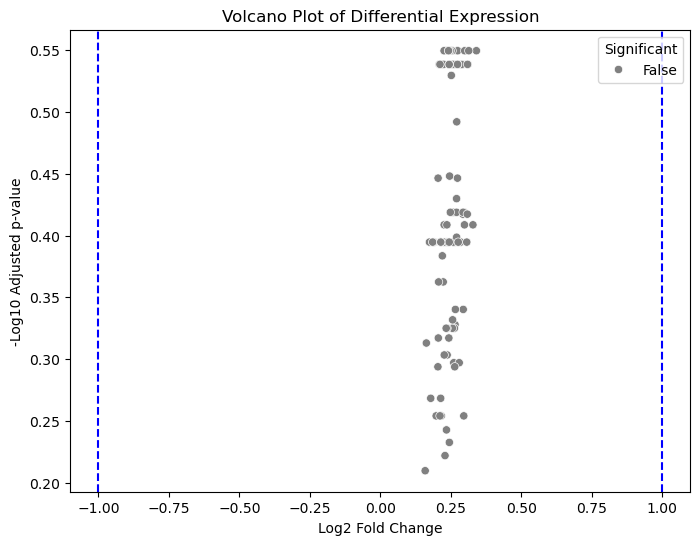

In [21]:
results_df['-log10_pvalue'] = -np.log10(results_df['adj_pvalue'])

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=results_df['log2FC'],
    y=results_df['-log10_pvalue'],
    hue=(results_df['adj_pvalue'] < 0.05),
    palette={True: 'red', False: 'grey'}
)
plt.axvline(x=1, color='blue', linestyle='--')
plt.axvline(x=-1, color='blue', linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted p-value')
plt.title('Volcano Plot of Differential Expression')
plt.legend(title='Significant', loc='upper right')
plt.show()

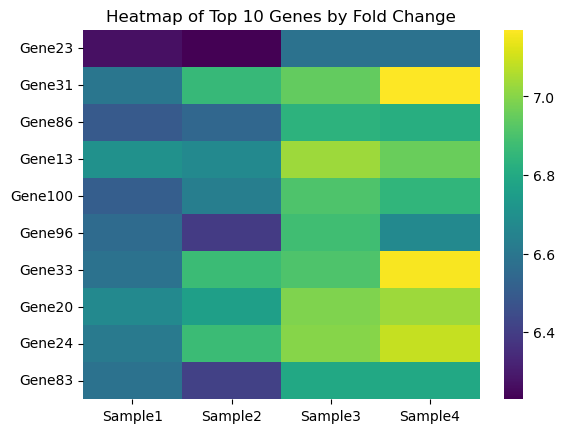

In [29]:
if not sig_genes.empty:
    top_genes = sig_genes.sort_values('adj_pvalue').head(10)['Gene']
    sns.heatmap(np.log2(counts.loc[top_genes] + 1), cmap='viridis', yticklabels=True)
    plt.title("Heatmap of Top 10 Differentially Expressed Genes")
    plt.show()
else:
    # Fall back: top 10 genes by fold change (absolute value)
    top_genes = results_df.reindex(results_df['FoldChange'].abs().sort_values(ascending=False).index).head(10)['Gene']
    sns.heatmap(np.log2(counts.loc[top_genes] + 1), cmap='viridis', yticklabels=True)
    plt.title("Heatmap of Top 10 Genes by Fold Change")
    plt.show()